# Air Passenger Forecasting


## Tujuan
Pada studi kasus saya kali ini, saya akan melakukan peralaman (*forecasting*) jumlah penumpang yang melakukan perjalanan menggunakan pesawat udara berdasarkan data *time-series*.

# DATA UNDERSTANDING

## Requirment

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from scipy import stats
from scipy.stats import skew
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from itertools import combinations
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA as ARIMA

## Deskripsi Data

## Load Data dan Menampilkan Beberapa Baris Pertama Dataset

In [2]:
df = pd.read_csv('/content/drive/MyDrive/PSD/TugasUTS/AirPassengers.csv')

df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


## Penjelasan Fitur

## EDA (Exploratory Data Analisys)

### Menampilkan Informasi Data

In [3]:
print(f"shape: {df.shape}")
print(f"columns: {df.columns}")
print(f"informations: {df.info}")

shape: (144, 2)
columns: Index(['Month', '#Passengers'], dtype='object')
informations: <bound method DataFrame.info of        Month  #Passengers
0    1949-01          112
1    1949-02          118
2    1949-03          132
3    1949-04          129
4    1949-05          121
..       ...          ...
139  1960-08          606
140  1960-09          508
141  1960-10          461
142  1960-11          390
143  1960-12          432

[144 rows x 2 columns]>


### Menampilkan Missing Value

In [4]:
df.isnull().sum()

,0
Month,0
#Passengers,0


### Statistik Deskriptif

In [5]:
df.describe()

,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


### Mengkonversi Tanggal

In [6]:
df['Date'] = pd.to_datetime(df['Month'])
df = df.drop(columns = 'Month')

df = df.set_index('Date')

df = df.rename(columns = {'#Passengers':'Passengers'})

df.head()

,Passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


### Distribusi Data

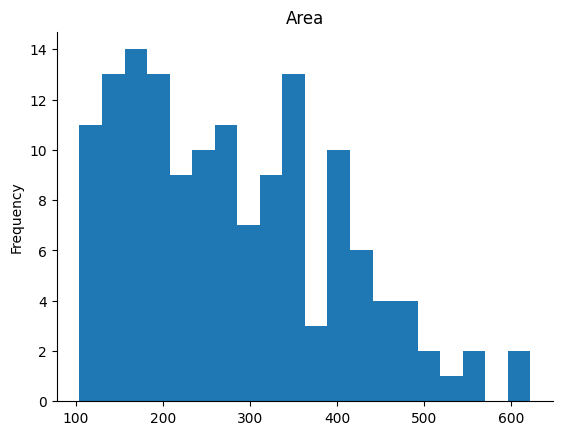

In [7]:
df['Passengers'].plot(kind='hist', bins=20, title='Area')
plt.gca().spines[['top', 'right',]].set_visible(False)

### Visualisasi Data Penumpang

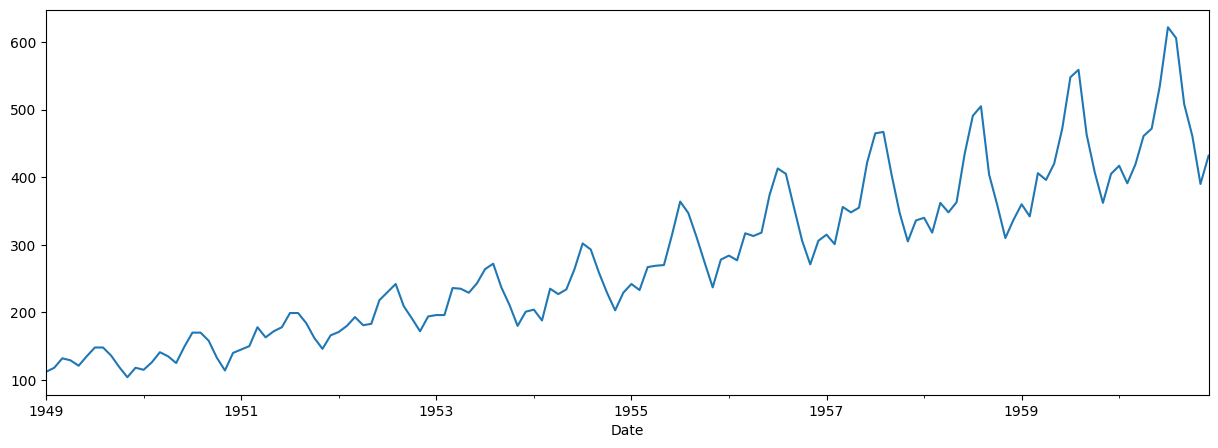

In [8]:
plt.figure(figsize = (15,5))
df['Passengers'].plot();

# Data Preprocessing

## Normalisasi Data

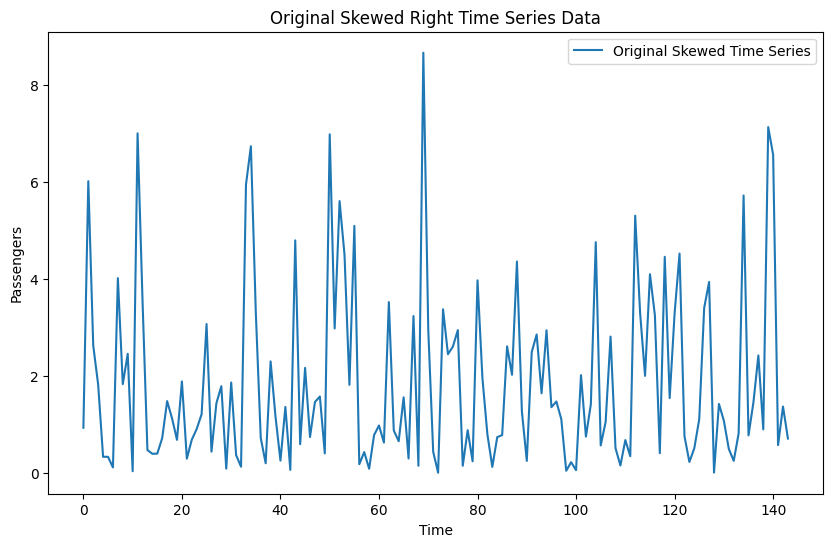

Original skewness: 0.5771


In [9]:
np.random.seed(42)
n = 144
t = np.arange(n)
y_skewed = np.random.exponential(scale=2, size=n)  # Skewed right distribution

plt.figure(figsize=(10, 6))
plt.plot(t, y_skewed, label='Original Skewed Time Series')
plt.title('Original Skewed Right Time Series Data')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.legend()
plt.show()

print(f"Original skewness: {skew(df['Passengers']):.4f}")

Tidak diperlukan normalisasi data

# Modeling

## Modeling Menggunakan SARIMA (Seasonal Autoregressive Integrated Moving Average)

In [10]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [11]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

### STL decomposition

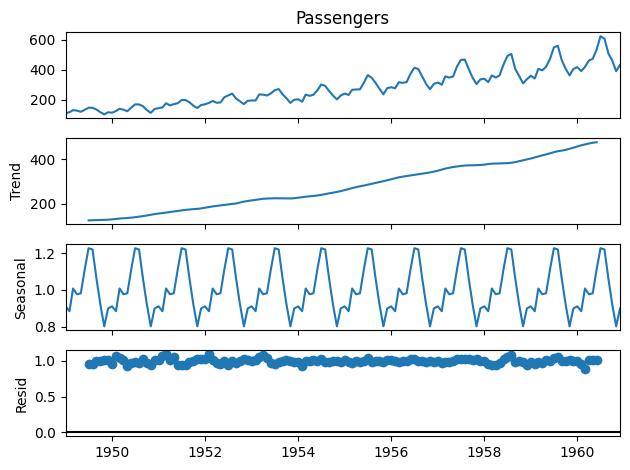

In [12]:
dec = sm.tsa.seasonal_decompose(df['Passengers'],period = 12, model = 'multiplicative').plot()
plt.show()

### Mengetes Stasioner

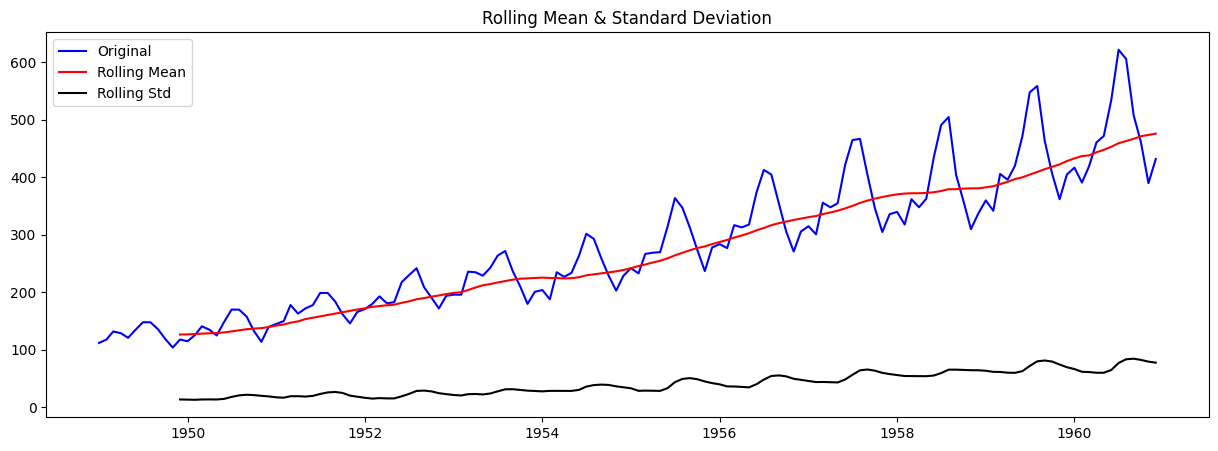

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [13]:
test_stationarity(df['Passengers'])

### ACF and PACF plots

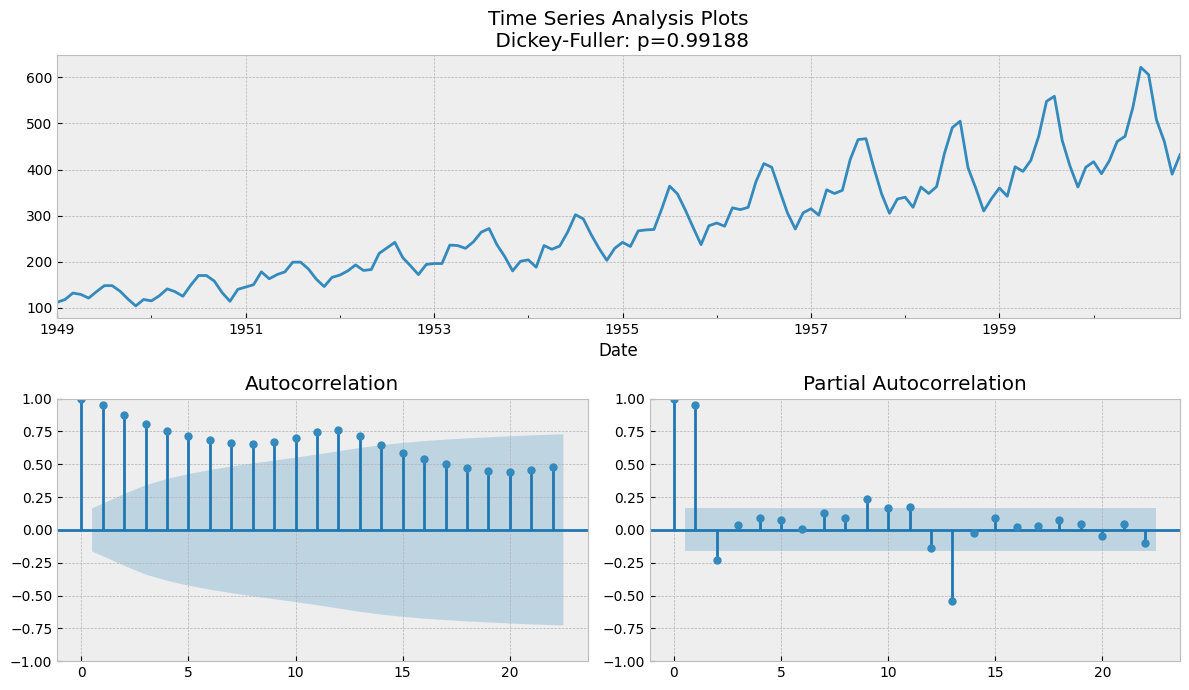

In [14]:
tsplot(df['Passengers'])

### Implementing SARIMA

In [15]:
model = sm.tsa.statespace.SARIMAX(df['Passengers'],order = (2,1,2),seasonal_order = (0,1,1,12))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                           Passengers   No. Observations:                  144
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -503.968
Date:                              Sun, 13 Oct 2024   AIC                           1019.935
Time:                                      18:09:38   BIC                           1037.186
Sample:                                  01-01-1949   HQIC                          1026.945
                                       - 12-01-1960                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3966      0.422      0.940      0.347      -0.430       1.223
ar.L2          0.35

### In - Sample Forecasting

In [16]:
size = int(len(df) - 30)
train, test = df['Passengers'][0:size], df['Passengers'][size:len(df)]

print('\t SARIMA MODEL : In - Sample Forecasting \n')

history = [x for x in train]
predictions = []

for t in range(len(test)):

    model = sm.tsa.statespace.SARIMAX(history,order = (2,1,2),seasonal_order = (0,1,1,12))
    model_fit = model.fit()

    output = model_fit.forecast()

    yhat = output[0]
    predictions.append(float(yhat))

    obs = test[t]
    history.append(obs)

    print('predicted = %f, expected = %f' % (yhat, obs))

	 SARIMA MODEL : In - Sample Forecasting 



<ipython-input-16-e6396e3ee086>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  obs = test[t]


predicted = 479.085765, expected = 491.000000
predicted = 490.553509, expected = 505.000000
predicted = 441.276125, expected = 404.000000
predicted = 357.274099, expected = 359.000000
predicted = 315.250484, expected = 310.000000
predicted = 347.831879, expected = 337.000000


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 344.251448, expected = 360.000000
predicted = 336.839209, expected = 342.000000
predicted = 387.593116, expected = 406.000000
predicted = 387.333485, expected = 396.000000
predicted = 408.192789, expected = 420.000000
predicted = 485.988165, expected = 472.000000
predicted = 529.031343, expected = 548.000000
predicted = 551.914006, expected = 559.000000
predicted = 459.061270, expected = 463.000000
predicted = 411.970100, expected = 407.000000
predicted = 358.421153, expected = 362.000000
predicted = 384.945724, expected = 405.000000
predicted = 420.144085, expected = 417.000000
predicted = 397.755393, expected = 391.000000
predicted = 451.335502, expected = 419.000000
predicted = 415.675182, expected = 461.000000
predicted = 465.295980, expected = 472.000000
predicted = 529.835405, expected = 535.000000
predicted = 599.299657, expected = 622.000000
predicted = 626.292198, expected = 606.000000
predicted = 513.891979, expected = 508.000000
predicted = 450.136741, expected =

### Visualisasi Prediksi

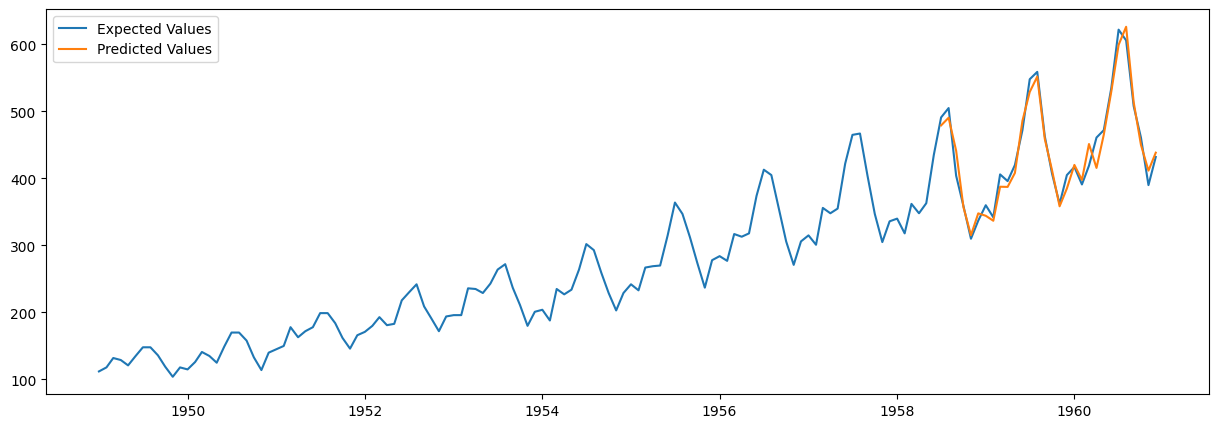

Test RMSE: 16.9251


In [17]:
predictions_series = pd.Series(predictions, index = test.index)
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(df['Passengers'],label = 'Expected Values')
plt.plot(predictions_series,label = 'Predicted Values');
plt.legend(loc="upper left")
plt.show()

error = np.sqrt(mean_squared_error(test,predictions))
print('Test RMSE: %.4f' % error)

## Modeling Menggunakan Ensemble Learning Bagging

### Menambahkan Bulan

In [18]:
df['Month'] = np.arange(len(df))
df

,Passengers,Month
Date,,
1949-01-01,112,0
1949-02-01,118,1
1949-03-01,132,2
1949-04-01,129,3
1949-05-01,121,4
...,...,...
1960-08-01,606,139
1960-09-01,508,140
1960-10-01,461,141


### Sliding Windows

In [19]:
def create_sliding_window_dataset(df, window_size):
    X, y = [], []
    for i in range(len(df) - window_size):
        X.append(df['Passengers'].values[i:i + window_size])
        y.append(df['Passengers'].values[i + window_size])
    return np.array(X), np.array(y)

# Membuat dataset sliding windows
window_size = 12
X_window, y_window = create_sliding_window_dataset(df, window_size)

print(f"Shape of X: {X_window.shape}")
print(f"Shape of y: {y_window.shape}")

# Contoh menampilkan data X dan y untuk beberapa window pertama
print("Beberapa data X (sliding window):")
for i in range(3):
    print(f"Window {i+1}: {X_window[i]}")

print("\nBeberapa data y (target):")
for i in range(3):
    print(f"Target {i+1}: {y_window[i]}")

Shape of X: (132, 12)
Shape of y: (132,)
Beberapa data X (sliding window):
Window 1: [112 118 132 129 121 135 148 148 136 119 104 118]
Window 2: [118 132 129 121 135 148 148 136 119 104 118 115]
Window 3: [132 129 121 135 148 148 136 119 104 118 115 126]

Beberapa data y (target):
Target 1: 115
Target 2: 126
Target 3: 141


### Membagi Data

In [20]:
# Membagi data menjadi training dan testing
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_window, y_window, test_size=0.2, shuffle=False)

# Scaling fitur menggunakan StandardScaler
scaler = StandardScaler()
X_train_w_scaled = scaler.fit_transform(X_train_w)
X_test_w_scaled = scaler.transform(X_test_w)

print(f"Shape of X_train: {X_train_w_scaled.shape}")
print(f"Shape of y_train: {y_train_w.shape}")
print(f"Shape of X_test: {X_test_w_scaled.shape}")
print(f"Shape of y_test: {y_test_w.shape}")

Shape of X_train: (105, 12)
Shape of y_train: (105,)
Shape of X_test: (27, 12)
Shape of y_test: (27,)


### Random Forest dan Gradient Boosting

In [21]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
gb_regressor = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Menggunakan VotingRegressor untuk menggabungkan prediksi
voting_regressor = VotingRegressor(estimators=[('rf', rf_regressor), ('gb', gb_regressor)])

# Inisialisasi TimeSeriesSplit untuk cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Menyimpan evaluasi metrik
rmse_scores, mae_scores, r2_scores = [], [], []

# Melakukan cross-validation untuk model ensemble
for train_index, test_index in tscv.split(X_train_w_scaled):
    X_train_cv, X_test_cv = X_train_w_scaled[train_index], X_train_w_scaled[test_index]
    y_train_cv, y_test_cv = y_train_w[train_index], y_train_w[test_index]

    # Melatih model ensemble
    voting_regressor.fit(X_train_cv, y_train_cv)

    # Melakukan prediksi
    y_pred_cv = voting_regressor.predict(X_test_cv)

    # Mengevaluasi model
    rmse = np.sqrt(mean_squared_error(y_test_cv, y_pred_cv))
    mae = mean_absolute_error(y_test_cv, y_pred_cv)
    r2 = r2_score(y_test_cv, y_pred_cv)

    # Menyimpan hasil evaluasi
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)

    print(f"Fold Results - RMSE: {rmse:.2f}, MAE: {mae:.2f}, R-squared: {r2:.2f}")

# Menghitung rata-rata hasil di seluruh fold
print(f"\nAverage RMSE: {np.mean(rmse_scores):.2f}")
print(f"Average MAE: {np.mean(mae_scores):.2f}")
print(f"Average R-squared: {np.mean(r2_scores):.2f}")

# Melatih model dengan seluruh data training untuk prediksi akhir
voting_regressor.fit(X_train_w_scaled, y_train_w)
y_test_pred = voting_regressor.predict(X_test_w_scaled)

# Evaluasi akhir model pada data test
final_rmse = np.sqrt(mean_squared_error(y_test_w, y_test_pred))
final_mae = mean_absolute_error(y_test_w, y_test_pred)
final_r2 = r2_score(y_test_w, y_test_pred)

print(f"\nFinal Evaluation on Test Set - RMSE: {final_rmse:.2f}, MAE: {final_mae:.2f}, R-squared: {final_r2:.2f}")



Fold Results - RMSE: 17.28, MAE: 12.60, R-squared: 0.48
Fold Results - RMSE: 24.17, MAE: 20.64, R-squared: 0.14
Fold Results - RMSE: 47.19, MAE: 36.21, R-squared: -0.21
Fold Results - RMSE: 23.46, MAE: 16.43, R-squared: 0.68
Fold Results - RMSE: 46.38, MAE: 36.84, R-squared: 0.41

Average RMSE: 31.70
Average MAE: 24.54
Average R-squared: 0.30

Final Evaluation on Test Set - RMSE: 51.01, MAE: 36.44, R-squared: 0.59


### Prediksi Menggunakan Sliding Window

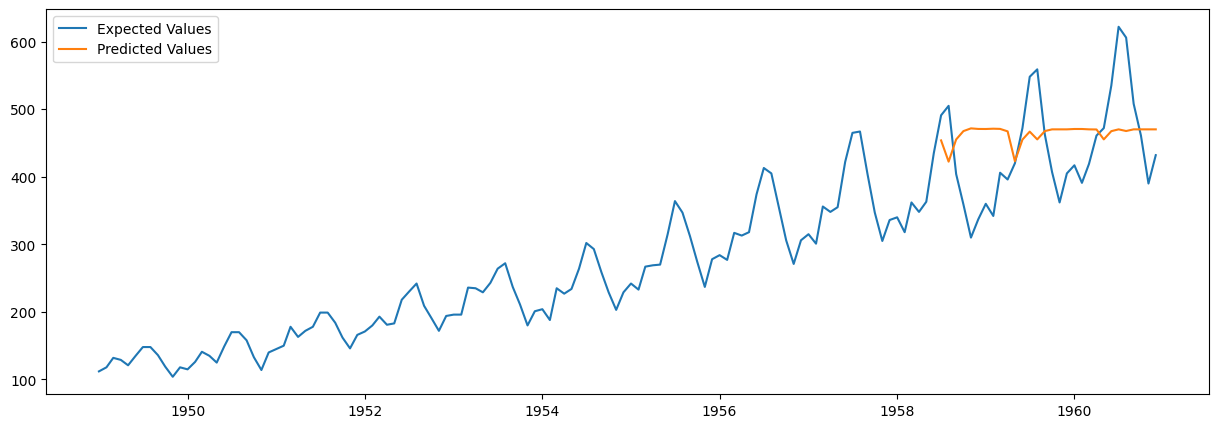

Test RMSE: 16.9251


In [25]:
last_window = df['Passengers'].values[-window_size:]
predictions_voting = []
for _ in range(30):
    last_window_scaled = scaler.transform(last_window.reshape(1, -1))
    next_pred = voting_regressor.predict(last_window_scaled)
    predictions_voting.append(next_pred[0])
    # Update the window with the new prediction
    last_window = np.append(last_window[1:], next_pred)

# Visualisasi prediksi
predictions_series = pd.Series(predictions_voting, index = test.index)
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(df['Passengers'],label = 'Expected Values')
plt.plot(predictions_series,label = 'Predicted Values');
plt.legend(loc="upper left")
plt.show()

error = np.sqrt(mean_squared_error(test,predictions))
print('Test RMSE: %.4f' % error)

# Conclusion

Prediksi yang lebih akurat adalah hasil dari Model SARIMA dengan hasil RMSE yaitu, 16.9251 dibandingkan dengan menggunakan Ensemble Learning yaitu, Rata-rata RMSE-nya adalah 51.01